TASK 1

In [8]:
import keras
from keras import layers

import numpy as np
import random
import io

In [9]:
path = keras.utils.get_file(
    "inferno.txt",
    origin="https://archive.org/stream/inferno00dant_2/inferno00dant_2_djvu.txt",
)
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

   8192/Unknown - 0s 0us/stepCorpus length: 714269
Total chars: 81
Number of sequences: 238077


In [10]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [11]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [12]:
epochs = 10
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

1860/1860 [==============================] - 242s 129ms/step - loss: 1.9009

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "  he  cried.  "by  several  years  the  "
...Generated:  counter  to  the  seen  the  sone  of  the  son  the  streen  of  the  strend  and  the  marned  the  been  to  the  stanting  the  son  the  count  of  the  stere  the  sinner  the  belon  the  son  the  so  the  seemed  the  seemon  to  the  seen  and  the  still  and  the  seeming  on  the  ware  and  the  seen  and  the  strense  and  the  seet  to  the  seemed  the  sinner  to  manti  strende
-
...Diversity: 0.5
...Generating with seed: "  he  cried.  "by  several  years  the  "
...Generated:  in  the  stand  the  seen  of  the  elare  sucher  of  the  inferno   i  shement  is  were  as  be  the  were  in  the  lore  of  the  shimas  to  among  in  the  wall  to  with  the  fersing  seeme  and  coppers  of  the  loare  as  he  are  in  the  rears  were  it  he  court  the  se

TASK 2

In [14]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [20]:
text = "Залиш надію всяк, хто сюди входить». Ці слова поспіхом виведені криваво-червоною фарбою"
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(text)

In [21]:
sequences = tokenizer.texts_to_sequences(text)

In [22]:
X = np.array([sequences[i : i + 40] for i in range(len(sequences) - 40)])
y = to_categorical([sequences[i + 40] for i in range(len(sequences) - 40)])

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [24]:
model.fit(X, y, batch_size=128, epochs=10)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.6717
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 3.3548
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 3.1954
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 3.0904
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 3.0136
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 2.9546
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 2.9078
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 2.8692
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 2.8360
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 2.8063


In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 31)                3999      
                                                                 
Total params: 70559 (275.62 KB)
Trainable params: 70559 (275.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


TASK 3

In [45]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = keras.utils.get_file("market.jpg", "https://i.imgur.com/FdJqr6O.jpeg")
style_reference_image_path = keras.utils.get_file(
    "night_city.jpg", "https://i.imgur.com/fmQuRWk.jpeg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

120648/120648 [==============================] - 0s 0us/step


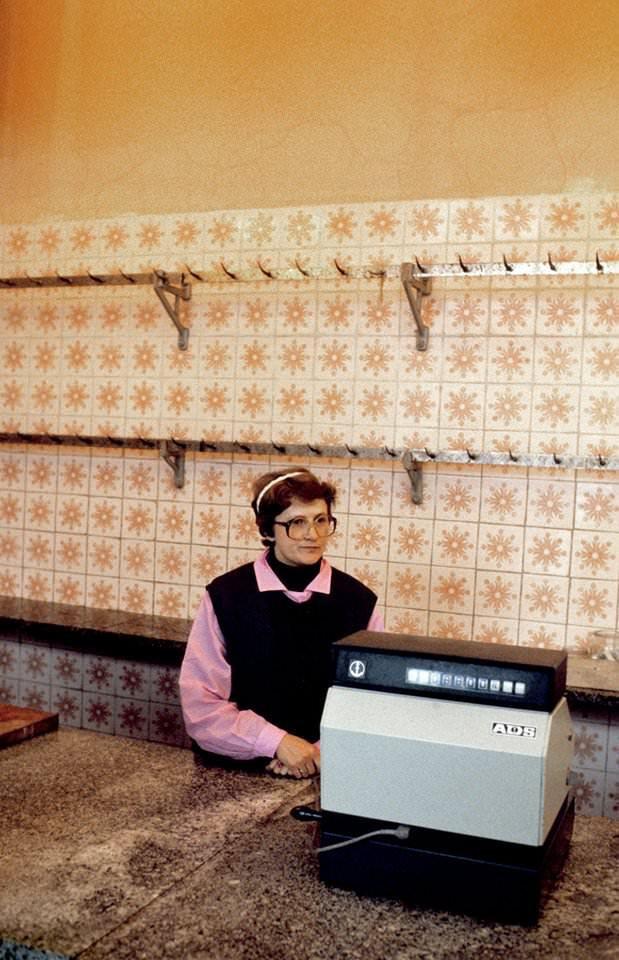

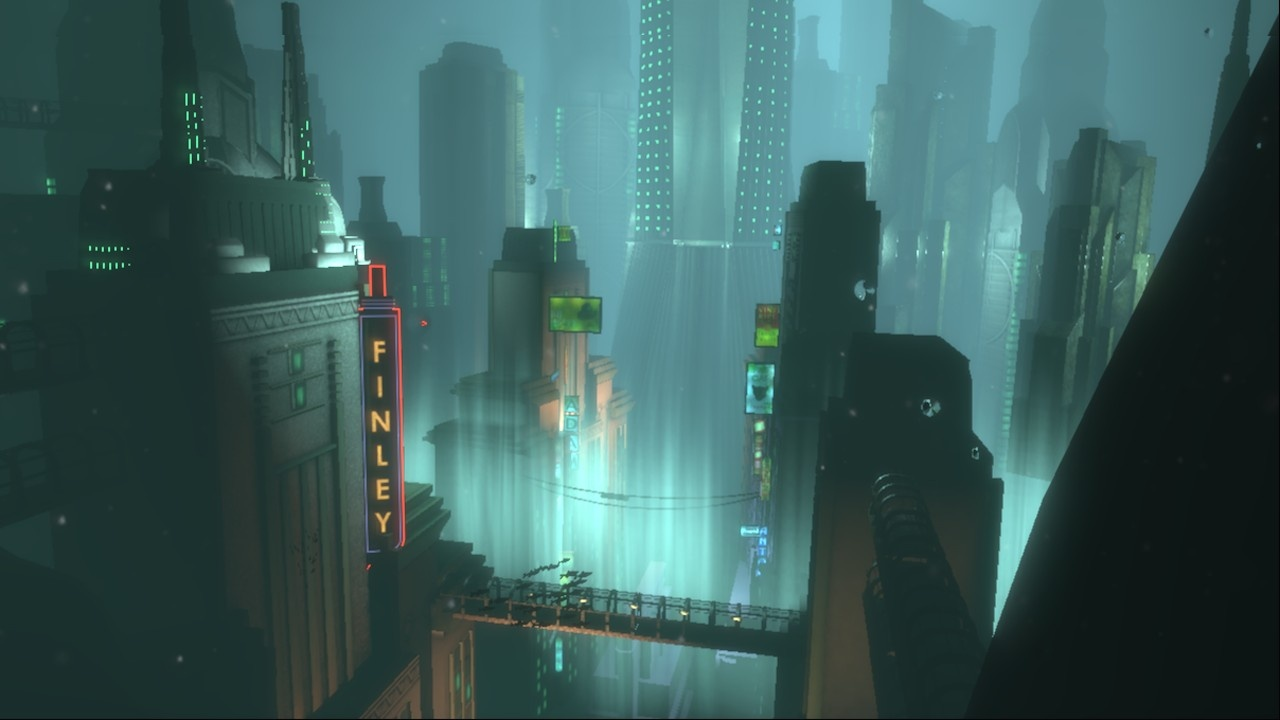

In [46]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [47]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [48]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [49]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [50]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [51]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [52]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=50, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 100
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 10: loss=7472.58
Iteration 20: loss=4263.59
Iteration 30: loss=3310.73
Iteration 40: loss=2837.79
Iteration 50: loss=2495.39
Iteration 60: loss=2231.62
Iteration 70: loss=2042.14
Iteration 80: loss=1900.54
Iteration 90: loss=1785.54
Iteration 100: loss=1689.53


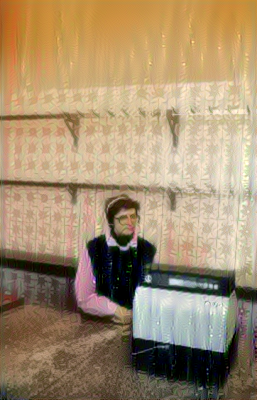

In [53]:
display(Image(result_prefix + "_at_iteration_100.png"))